Imports

In [3]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [27]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt


import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

Load data and define the ImageDataset

In [10]:
train_df = pd.read_csv("train.csv")
#test_df  = pd.read_csv("test_v2.csv")
df.head()

,Unnamed: 0,file_name,label
0,0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [33]:
class ImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform #save the dataframe, imagedirectory and transform

    def __len__(self):
        return len(self.df) #rows in the df

    def __getitem__(self, idx):
        row = self.df.iloc[idx] #takes one row from the df and makes the image path for it, open the image and convert to rgb
        img_path = os.path.join(self.img_dir, row["file_name"])
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(row["label"], dtype=torch.long) #creates a label and changes it to a pytorch tensor

        if self.transform:
            image = self.transform(image) #use the transform

        return image, label

In [48]:
transform = transforms.Compose([
    transforms.Resize((256, 256)), #resize image to 256x256px
    transforms.RandomHorizontalFlip(p=0.5), # random right or left flip for generalization
    transforms.RandomRotation(10), #turn of up to 10 degrees
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # image generalization for model robustness
    transforms.ToTensor(), #turns the image into a pytorch tensor and normalizes pixels from 0-1
])

In [49]:
train_dataset = ImageDataset(train_df, "", transform) #load the training dataset,
#test_dataset  = ImageDataset(test_df,  "test_data_v2/", transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #for training take a batch of 32 images at once for faster training, and shuffle the images each epoch for generalization
#test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False) #For testing shuffle is turned off to get repetable results

Image shape: torch.Size([3, 256, 256])
Label: tensor(0)


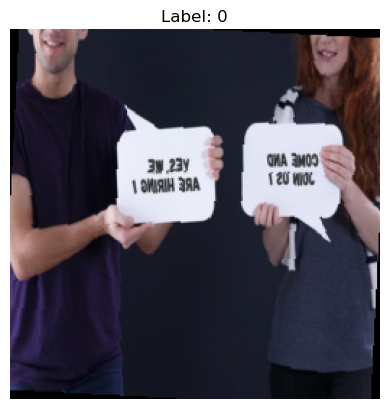

In [53]:
image, label = train_dataset[10001]   
print("Image shape:", image.shape)
print("Label:", label)
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {label.item()}")
plt.axis("off")
plt.show()